In [1]:
import uproot
import numpy as np
import math
from matplotlib import pylab as plt
from ROOT import TTree, TFile, TH2D, TCanvas, TH1F, gROOT
from root_numpy import array2hist, hist2array, fill_hist, tree2array, root2array, list_trees
import pandas as pd
from root_pandas import read_root


Welcome to JupyROOT 6.22/02


## Inspect what variables are inside the file

In [2]:
file = uproot.open("/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/output3.root")
# print(file.keys())
print(file['PhaseSpace'].keys())

[b'AtomicNumber', b'Ekine', b'Weight', b'Mass', b'X', b'Y', b'Z', b'dX', b'dY', b'dZ', b'ParticleName', b'ProductionVolume', b'CreatorProcess', b'ProcessDefinedStep', b'TrackID', b'ParentID', b'EventID', b'RunID', b'TOut', b'TProd']


## Load root files. 
#### Here I am creating a pandas data frame for each fieldsize/dataset and storing it in a dictionary where you access the pandas

In [6]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/output*.root"
]


data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','dZ','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/output*.root   

/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/output*.root   

/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/output*.root   

/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/output*.root   



### Calculate angles from directional vectors

In [3]:
for j,files_g in enumerate(filenames_g):

    df=data_frame_dict[files_g]
    data_frame_dict[files_g]['dXdY']=(data_frame_dict[files_g].dX**2+data_frame_dict[files_g].dY**2)**0.5
    ratioThetaXY=data_frame_dict[files_g].dXdY/data_frame_dict[files_g].dZ
    ratioThetaX=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    ratioThetaY=data_frame_dict[files_g].dY/data_frame_dict[files_g].dZ
    data_frame_dict[files_g]['thetaXY']=ratioThetaXY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaX']=ratioThetaX.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaY']=ratioThetaY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['XY']=(data_frame_dict[files_g].X**2+data_frame_dict[files_g].Y**2)**0.5

In [5]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['ProductionVolume'].value_counts())

b'world_log'         236514
b'jaws_x2_log'       217701
b'jaws_x1_log'       216172
b'mlc_leaf_log'       50707
b'mlc_y6_log'         25858
b'mlc_y5_log'         19810
b'mlc_y7_log'         18944
b'mlc_y4_log'         15236
b'mlc_y3_log'         14505
b'jaws_y2_log'        12059
b'mlc_y8_log'         11990
b'jaws_y1_log'        11534
b'mlc_y2_log'          9938
b'mlc_y1_log'          7483
b'mlc_y9_log'          7378
b'mlc_y0_log'          5937
b'jaws_x2Vol_log'      2707
b'jaws_x1Vol_log'      2660
b'mlc_y10_log'         2609
b'mlc_system_log'      1838
b'mlc_y11_log'          774
b'mlc_y12_log'          431
b'mlc_y13_log'          319
b'jaws_y1Vol_log'       104
b'jaws_y2Vol_log'        97
Name: ProductionVolume, dtype: int64
b'world_log'         1128049
b'jaws_x1_log'        566814
b'jaws_x2_log'        565793
b'mlc_leaf_log'       306045
b'mlc_y8_log'         110166
b'mlc_y9_log'         107979
b'mlc_y7_log'         107891
b'mlc_y6_log'         103128
b'mlc_y5_log'          78292
b'

### Checking how many entries in files with different weights (now all weights are 1 as biasing is turned off)

In [6]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['Weight'].value_counts())

1.0    893305
Name: Weight, dtype: int64
1.0    3531569
Name: Weight, dtype: int64
1.0    7050126
Name: Weight, dtype: int64
1.0    10842878
Name: Weight, dtype: int64


### ..and total entries (without taking into account the weight)

In [7]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['X'].count())

893305
3531569
7050126
10842878


### ..and with the weight, so we take into account the biasing 

In [8]:
for files_g in filenames_g:
    df=data_frame_dict[files_g]
    print(df['Weight'].sum(axis = 0, skipna = True) ) 
    #skipping if there are any NANs


893305.0
3531569.0
7050126.0
10842878.0


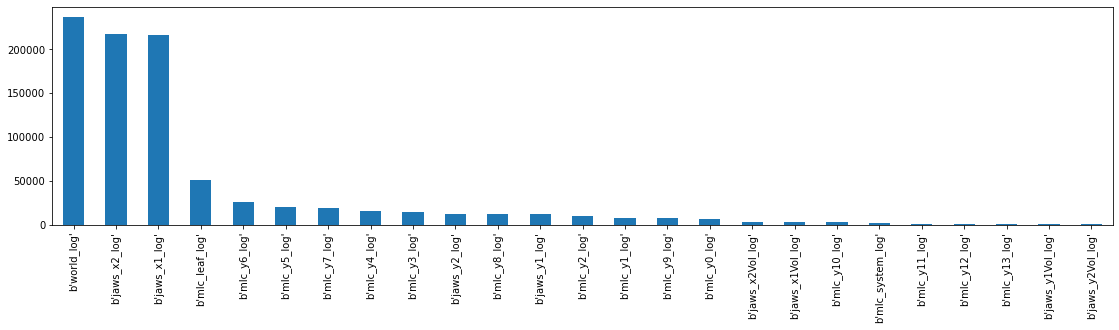

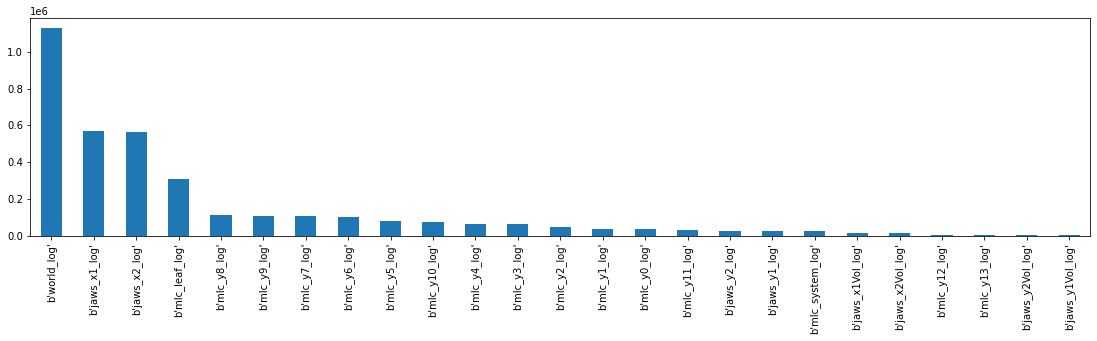

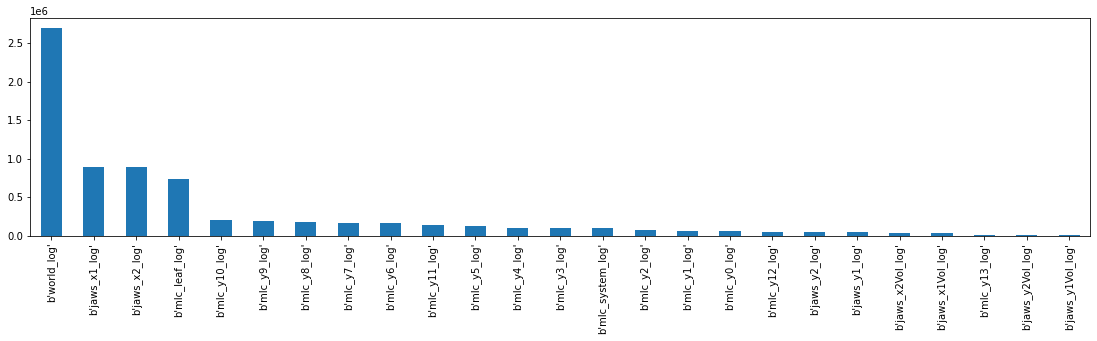

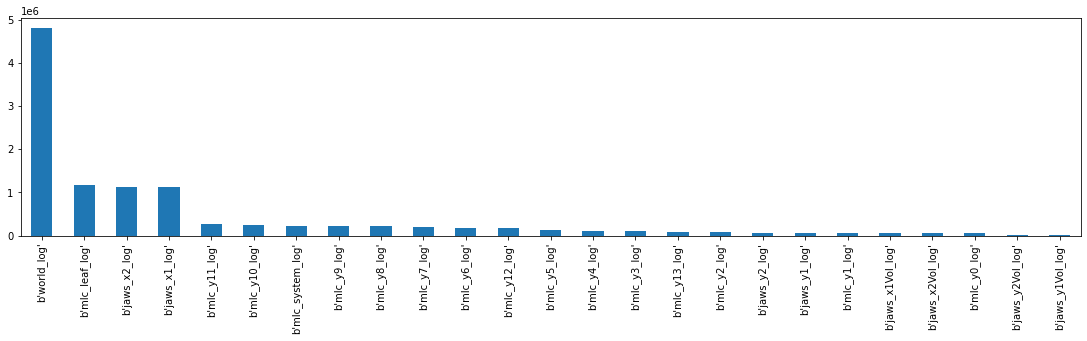

In [9]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(19,4))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    df['ProductionVolume'].value_counts().plot(kind='bar')



#     _=plt.hist(df['ProductionVolume'])

In [55]:
# subdf=df["ProductionVolume"][df['ProductionVolume'].str.contains(b"world_log")]
# # df.loc[:,"ProductionVolume"]
# subdf
# df['ProductionVolume'].str.contains(b"world_log")
df

,X,Y,dX,dY,dZ,Weight,Ekine,ProductionVolume,CreatorProcess,dXdY,thetaXY,thetaX,thetaY,XY
0,82.781898,44.251480,0.529525,-0.761656,-0.373475,1.0,0.838189,jaws_x1,b'phot',0.927640,-68.104432,-54.832395,-54.832395,93.867119
1,-62.340248,-3.633132,-0.187345,-0.140106,-0.972251,1.0,0.123098,jaws_x1,b'compt',0.233940,-13.536017,10.912293,10.912293,62.446026
2,44.804558,-25.360569,0.103621,-0.063042,-0.992617,1.0,5.650195,b'world_log',b'compt',0.121292,-6.970191,-5.962667,-5.962667,51.484047
3,-21.352638,-90.427437,-0.068489,-0.163184,-0.984216,1.0,1.561793,b'world_log',b'compt',0.176974,-10.198715,3.982645,3.982645,92.914246
4,-40.672119,38.231785,0.314169,0.112664,-0.942658,1.0,0.790718,b'mlc_y0_log',b'compt',0.333760,-19.507012,-18.441538,-18.441538,55.820164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10842873,95.942749,-22.321810,0.434169,-0.293684,-0.851614,1.0,1.669700,b'world_log',b'compt',0.524169,-31.628358,-27.027043,-27.027043,98.505196
10842874,20.255283,-5.819820,-0.267727,-0.200952,-0.942306,1.0,0.049273,b'world_log',b'compt',0.334753,-19.567423,15.868906,15.868906,21.074791
10842875,24.513884,-7.854311,0.360728,0.791067,-0.494053,1.0,0.016511,b'world_log',b'eIoni',0.869432,-60.423309,-36.153039,-36.153039,25.741419
10842876,44.636482,-80.681488,0.137970,-0.020687,-0.990220,1.0,1.247485,b'world_log',b'compt',0.139512,-8.023681,-7.936117,-7.936117,92.205849


### Plotting XY plane distributed electrons

10x10
20x20
30x30
40x40


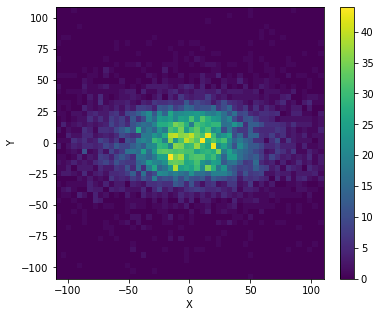

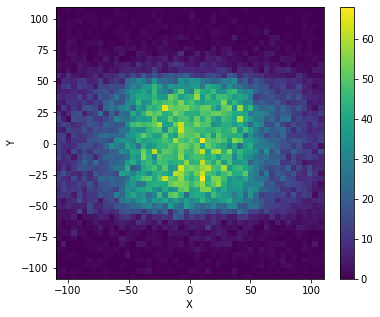

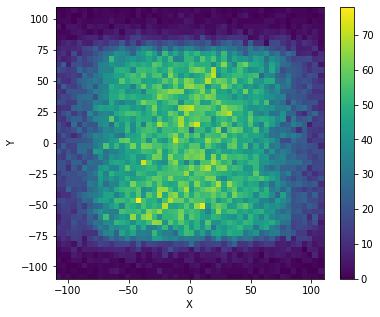

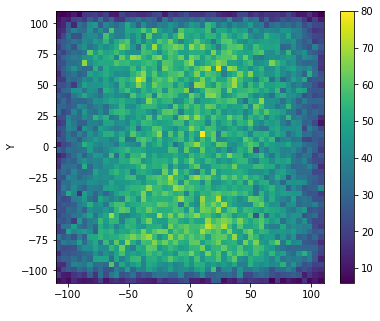

In [5]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    histo=ax.hist2d(df['X'],df['Y'],bins=(50,50))
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(histo[3],ax=ax)
#     ax.show()
    print(files_g[30:-24])
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_norm.png")

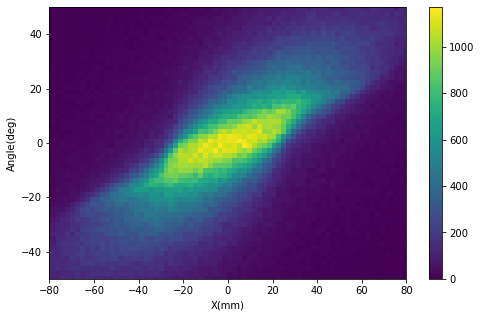

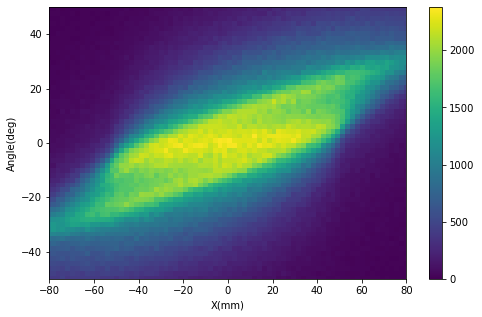

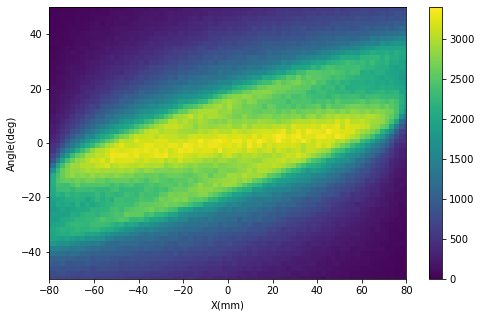

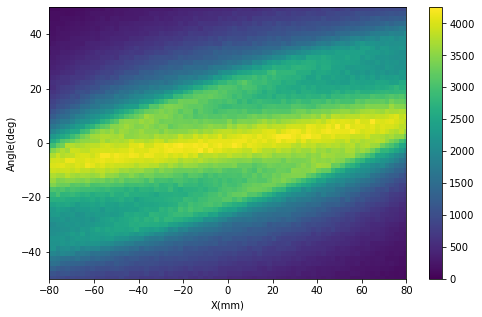

In [17]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['X'],-df['thetaX'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(-50,50)
    ax.set_xlabel("X(mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_Angle.png")

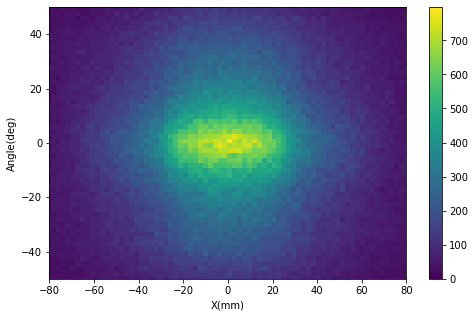

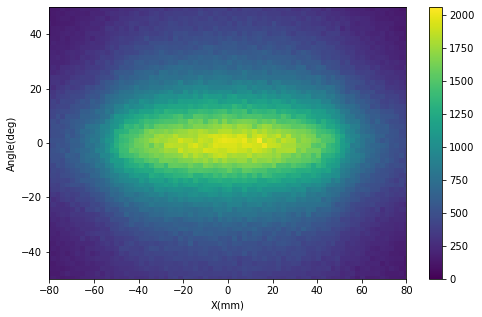

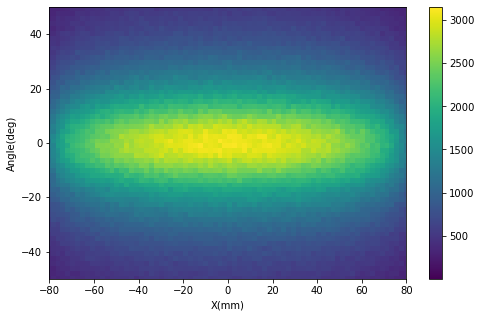

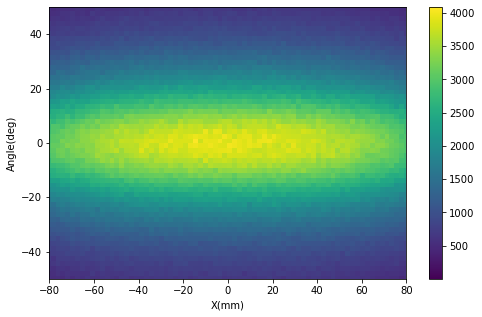

In [21]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['X'],df['thetaY'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(-50,50)
    ax.set_xlabel("X(mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_Angle_norm.png")

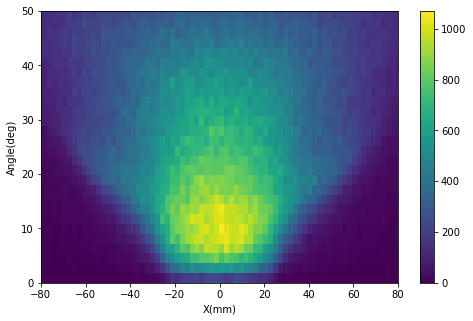

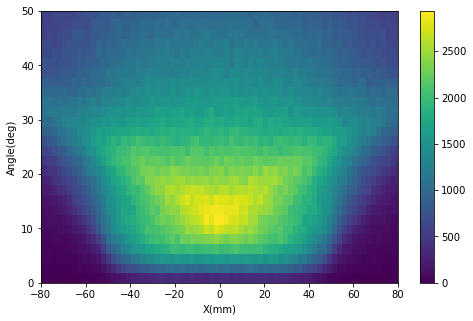

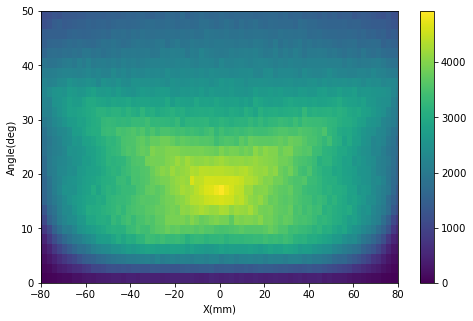

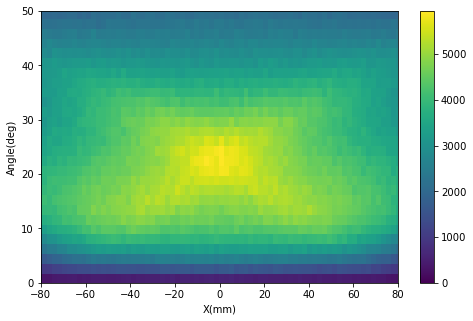

In [26]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['X'],-df['thetaXY'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(0,50)
    ax.set_xlabel("X(mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_Angle_norm.png")

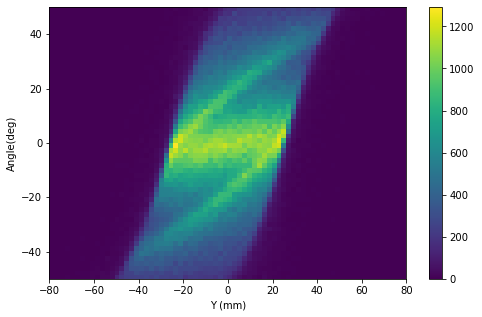

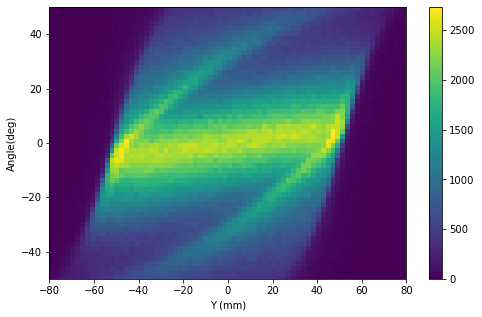

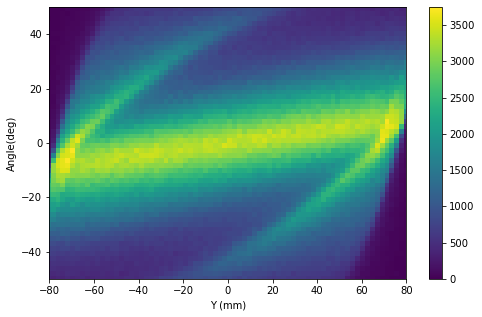

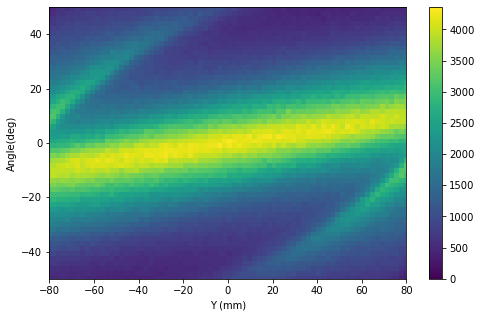

In [27]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['Y'],-df['thetaY'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(-50,50)
    ax.set_xlabel("Y (mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_YAngle.png")

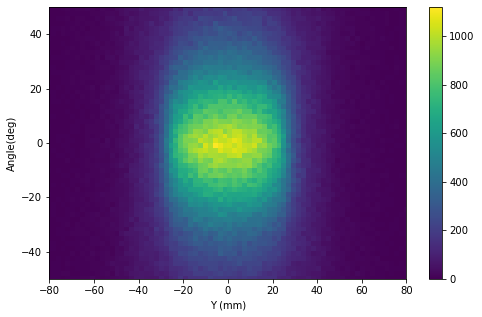

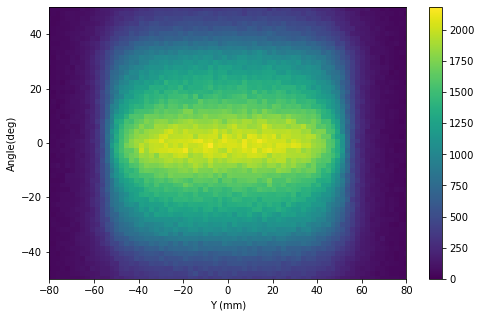

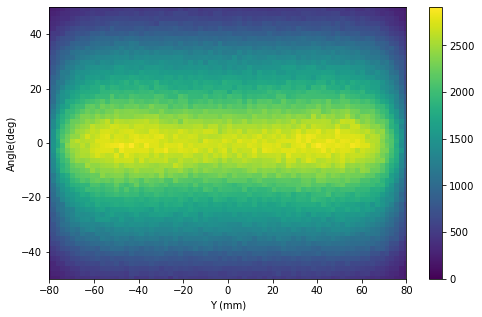

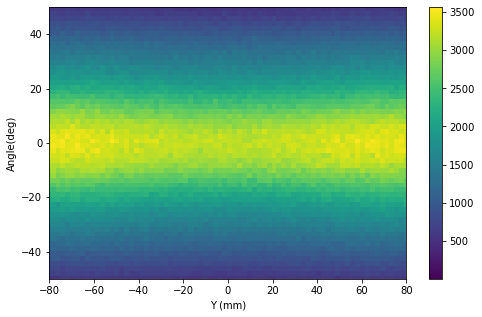

In [20]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['Y'],df['thetaX'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(-50,50)
    ax.set_xlabel("Y (mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_YAngle.png")

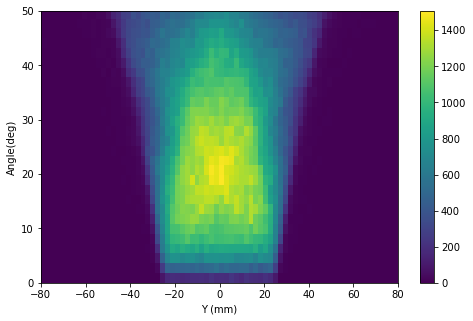

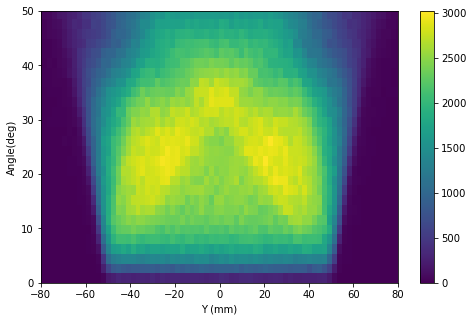

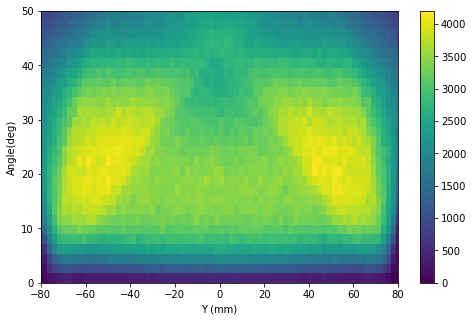

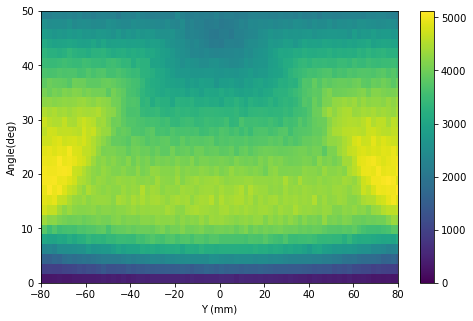

In [25]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    df=data_frame_dict[files_g]
    
    histo=ax.hist2d(df['Y'],-df['thetaXY'],bins=(100,100))
    #using _ just suppresses the output if plt.hist2d
    ax.set_xlim(-80,80)
    ax.set_ylim(0,50)
    ax.set_xlabel("Y (mm)")
    ax.set_ylabel("Angle(deg)")
    fig.colorbar(histo[3],ax=ax)
    fig.savefig(f"/home/lb8075/linac/PaperPlots/Phase2_{files_g[30:-24]}_YAngle.png")

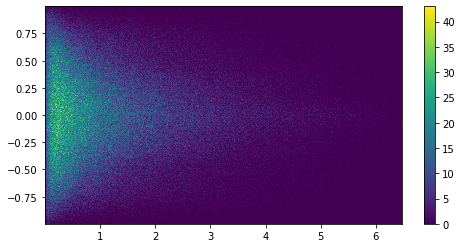

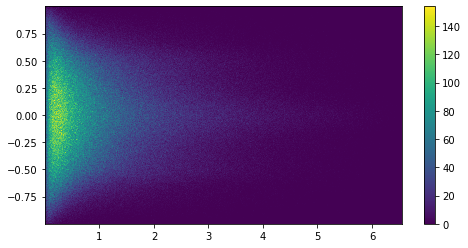

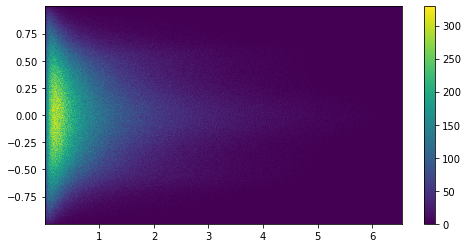

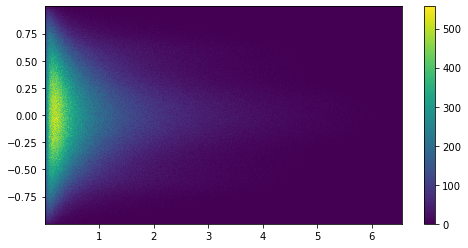

In [28]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['Ekine'],df['dX'],bins=(500,500))
#     plt.xlim(-80,80)
#     plt.ylim(-0.7,0.7)
    plt.colorbar()
    plt.show()


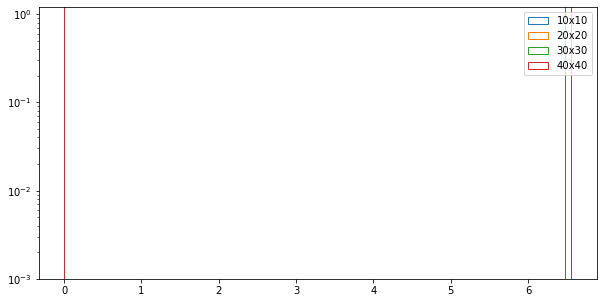

In [29]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        _=plt.hist(df['Ekine'],histtype='step',bins=(80),label=files_g[30:-24])

plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
plt.ylim(0.001,1.2)
plt.show()


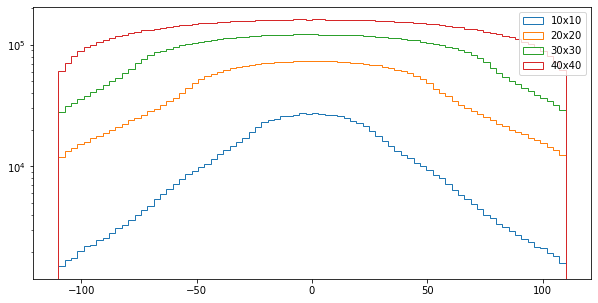

In [30]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

        _=plt.hist(data_frame_dict[files_g]['X'],histtype='step',bins=(80),label=files_g[30:-24])

plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


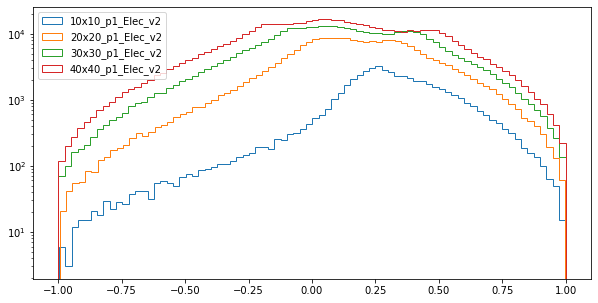

In [26]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

    _=plt.hist(data_frame_dict[files_g]['dX'][data_frame_dict[files_g]['X']<40][data_frame_dict[files_g]['X']>30],histtype='step',bins=(80),label=files_g[30:-24])

plt.yscale('log')
plt.legend(loc="upper left")
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


## Phase 1AB No bias (bias1)

In [2]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_ZeroBias/output-PhS_bias1_7*.root"
]

In [ ]:
data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','dZ','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is


/work/lb8075/PhaseSpaces/PhS1AB_Gamma_ZeroBias/output-PhS_bias1_7*.root   



In [ ]:
for j,files_g in enumerate(filenames_g):

    df=data_frame_dict[files_g]
    data_frame_dict[files_g]['dXdY']=(data_frame_dict[files_g].dX**2+data_frame_dict[files_g].dY**2)**0.5
    ratioThetaXY=data_frame_dict[files_g].dXdY/data_frame_dict[files_g].dZ
    ratioThetaX=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    ratioThetaY=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    data_frame_dict[files_g]['thetaXY']=ratioThetaXY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaX']=ratioThetaX.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaY']=ratioThetaY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['XY']=(data_frame_dict[files_g].X**2+data_frame_dict[files_g].Y**2)**0.5


In [ ]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
#     dfsubgamma=df[["ProductionVolume","CreatorProcess","Weight"]][df['ParticleName']==b"gamma"]
    df["ProductionVolume"].value_counts().plot(kind='bar',logy=True)


In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    plt.hist2d(df['X'],df['Y'],bins=(60,60))
    plt.colorbar()
    plt.savefig("/home/lb8075/linac/PaperPlots/Phase1_XY.png")

In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['X'][df['Y']<10][df['Y']>-10],-df['thetaX'][df['Y']<10][df['Y']>-10],bins=(200,200))
    plt.ylim(-30,30)
    plt.colorbar()

In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['XY'],df['thetaXY'],bins=(100,200))
    plt.ylim(-20,0)
    plt.colorbar()